# SQuAD-like dataset Stats

In [1]:
import collections
import copy
import json
from math import log2
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import random
import re
import spacy
import statistics as st
import string
import threading
import time
from time import sleep

In [2]:
ARTIFACTS_PATH = '../artifacts'

In [3]:
LANGS = {
    'en': {
        'region_code': 'en',
        'lang_name': 'English',
        'lang_code': 'en-EN',
        'spacy_dict': 'en_core_web_sm',
    },
    'es': {
        'region_code': 'es',
        'lang_name': 'Spanish',
        'lang_code': 'es-ES',
        'spacy_dict': 'es_core_news_sm',
    },
    'ru': {
        'region_code': 'ru',
        'lang_name': 'Russian',
        'lang_code': 'ru-RU',
        'spacy_dict': 'ru_core_news_sm',
    },
    'vi': {
        'region_code': 'vi',
        'lang_name': 'Vietnamese',
        'lang_code': 'vi-VN',
        'spacy_dict': '',
    },
    'ja': {
        'region_code': 'ja',
        'lang_name': 'Japanese',
        'lang_code': 'ja-JP',
        'spacy_dict': 'ja_core_news_sm',
    },
}

## Tokenization

In [4]:
def get_word_tokenizer(dictionary_name=None, region_code=None, basic_token=False):
    if dictionary_name == '':
        if region_code == 'en':
            from spacy.lang.en import English as NlpTokenizer
        elif region_code == 'es':
            from spacy.lang.es import Spanish as NlpTokenizer
        elif region_code == 'ru':
            from spacy.lang.ru import Russian as NlpTokenizer
        elif region_code == 'vi':
            from spacy.lang.vi import Vietnamese as NlpTokenizer
        elif region_code == 'ja':
            from spacy.lang.ja import Japanese as NlpTokenizer
        else:
            raise Exception('Unknown region code: %s' % region_code)
        nlp = NlpTokenizer()
        nlp.add_pipe('sentencizer')
    else:
        nlp = spacy.load(dictionary_name)
    
    if basic_token:
        return lambda text : [token.text for token in nlp(text)]
    else:
        return lambda text : [(token.text, (token.lemma_ if token.lemma_ != '' else token.text), [token.idx, token.idx + len(token.text)]) for token in nlp(text)]

In [5]:
def get_sent_tokenizer(dictionary_name=None, region_code=None):
    if region_code == 'vi':
        from spacy.lang.vi import Vietnamese
        nlp = Vietnamese()
        nlp.add_pipe('sentencizer')
    else:
        nlp = spacy.load(dictionary_name)
    
    return lambda text : [sent.text.strip() for sent in nlp(text).sents]

In [6]:
def normalize_text(text):
    text = ''.join(x for x in text if x not in set(string.punctuation))
    return text.lower().strip()

In [7]:
text = '¡Hola mundo! ¡Adiós mundo!'
region_code = 'es'

dictionary_name = LANGS[region_code]['spacy_dict']
tokenizer = get_word_tokenizer(dictionary_name=dictionary_name, region_code=region_code)
tokenizer(text)

[('¡', '¡', [0, 1]),
 ('Hola', 'Hola', [1, 5]),
 ('mundo', 'mundo', [6, 11]),
 ('!', '!', [11, 12]),
 ('¡', '¡', [13, 14]),
 ('Adiós', 'Adiós', [14, 19]),
 ('mundo', 'mundo', [20, 25]),
 ('!', '!', [25, 26])]

In [8]:
text = 'Hola mundo. ¡Adiós mundo!'
region_code = 'es'

dictionary_name = LANGS[region_code]['spacy_dict']
tokenizer = get_sent_tokenizer(dictionary_name=dictionary_name, region_code=region_code)
tokenizer(text)

['Hola mundo.', '¡Adiós mundo!']

## Formulas

In [9]:
def entropy_shannon(boe):
    total = sum(boe.values())
    return -1 * sum([freq / total * log2(freq / total) for freq in boe.values()])

In [10]:
text = '¡Hola mundo! ¡Adiós mundo!'
region_code = 'es'

tokenizer = get_word_tokenizer(dictionary_name=dictionary_name, region_code=region_code)
text = normalize_text(text)
words = [x[0] for x in tokenizer(text)]
boe = collections.Counter(words)

entropy_shannon(boe)

1.9182958340544893

## Stats

In [11]:
class ItemPicker():
    def __init__(self, dataset, timeout=60, sleep_interval=1):
        self._n_items = len(dataset)
        self._dataset_keys = list(dataset.keys())
        self._dataset_values = list(dataset.values())
        self._idx = 0
        self._timeout = timeout
        self._sleep_interval = sleep_interval
        self._locked = False
    
    def pick(self):
        self.lock()
        if self._idx >= self._n_items:
            item_name = None
            item_props = None
        else:
            item_name = self._dataset_keys.pop(0)
            item_props = self._dataset_values.pop(0)
            self._idx += 1
        self.unlock()
        return item_name, item_props

    def lock(self):
        start_time = time.time()
        while self._locked:
            end_time = time.time()
            if end_time - start_time >= self._timeout:
                raise Exception('Cannot pick an item (timeout)')
            sleep(self._sleep_interval)
        self._locked = True
    
    def unlock(self):
        self._locked = False

In [12]:
def get_stats_dataset(input_file, region_code, verbose=False):
    dictionary_name = LANGS[region_code]['spacy_dict']
    stats = {
        'n_items': [],
        'n_words': [],
        'entropy_shannon_chars': [],
        'entropy_shannon_words': [],
        'n_words_ps': [],
        'entropy_shannon_chars_ps': [],
        'entropy_shannon_words_ps': [],
    }

    basic_tokenizer = get_word_tokenizer(dictionary_name=dictionary_name, region_code=region_code, basic_token=True)
    sent_tokenizer = get_sent_tokenizer(dictionary_name=dictionary_name, region_code=region_code)

    with open(input_file, 'r', encoding='utf8') as fp:
        dataset = json.load(fp)

    if verbose:
        print('Parsing elements...')
    for i, item in enumerate(dataset['data']):
        if verbose:
            print('- Item %d / %d' % (i + 1, len(dataset['data'])), end='\r')
        
        for paragraph_item in item['paragraphs']:
            context = paragraph_item['context']
            norm_context = normalize_text(context)
            words = basic_tokenizer(norm_context)
            freq_chars = collections.Counter(list(norm_context))
            freq_words = collections.Counter(words)
            
            stats['n_items'].append(len(paragraph_item['qas']))
            stats['n_words'].append(len(words))
            stats['entropy_shannon_chars'].append(entropy_shannon(freq_chars))
            stats['entropy_shannon_words'].append(entropy_shannon(freq_words))
            
            # Same stats, but in this case per sentence
            for sentence in sent_tokenizer(context):
                norm_sentence = normalize_text(sentence)
                if norm_sentence == '':
                    continue
                words = basic_tokenizer(norm_sentence)
                freq_chars = collections.Counter(list(norm_sentence))
                freq_words = collections.Counter(words)
                stats['n_words_ps'].append(len(words))
                stats['entropy_shannon_chars_ps'].append(entropy_shannon(freq_chars))
                stats['entropy_shannon_words_ps'].append(entropy_shannon(freq_words))
    if verbose:
        print()
    
    return stats

In [13]:
def thread_main(end_status, item_picker, all_stats):
    while True:
        dataset_name, dataset_props = item_picker.pick()
        if dataset_name is None:
            break
        print('Processing dataset: %s' % dataset_name)
        dataset_stats = get_stats_dataset(dataset_props[0], dataset_props[1])
        all_stats[dataset_name] = dataset_stats
        print('Finished dataset: %s' % dataset_name)
    end_status.append(1)

In [14]:
datasets = {
    'squad': ['../data/squad/dev-v1.1.json', 'en'],
    'squad-es': ['../data/squad/dev-v1.1-es.json', 'es'],
    'squad-ja': ['../data/squad/dev-v1.1-ja.json', 'ja'],
    'xquad-es': ['../data/xquad/xquad.es.json', 'es'],
    'xquad-ru': ['../data/xquad/xquad.ru.json', 'ru'],
    'xquad-vi': ['../data/xquad/xquad.vi.json', 'vi'],
    'synthetic-es-top1': ['../data/synthetic_google_top_n/es/top_1/train-synthetic.json', 'es'],
    'synthetic-ru-top1': ['../data/synthetic_google_top_n/ru/top_1/train-synthetic.json', 'ru'],
    'synthetic-vi-top1': ['../data/synthetic_google_top_n/vi/top_1/train-synthetic.json', 'vi'],
    'synthetic-ja-top1': ['../data/synthetic_google_top_n/ja/top_1/train-synthetic.json', 'ja'],
    'synthetic-es-top2': ['../data/synthetic_google_top_n/es/top_2/train-synthetic.json', 'es'],
    'synthetic-ru-top2': ['../data/synthetic_google_top_n/ru/top_2/train-synthetic.json', 'ru'],
    'synthetic-vi-top2': ['../data/synthetic_google_top_n/vi/top_2/train-synthetic.json', 'vi'],
    'synthetic-ja-top2': ['../data/synthetic_google_top_n/ja/top_2/train-synthetic.json', 'ja'],
    'synthetic-es-top3': ['../data/synthetic_google_top_n/es/top_3/train-synthetic.json', 'es'],
    'synthetic-ru-top3': ['../data/synthetic_google_top_n/ru/top_3/train-synthetic.json', 'ru'],
    'synthetic-vi-top3': ['../data/synthetic_google_top_n/vi/top_3/train-synthetic.json', 'vi'],
    'synthetic-ja-top3': ['../data/synthetic_google_top_n/ja/top_3/train-synthetic.json', 'ja'],
    'synthetic-es-top5': ['../data/synthetic_google_top_n/es/top_5/train-synthetic.json', 'es'],
    'synthetic-ru-top5': ['../data/synthetic_google_top_n/ru/top_5/train-synthetic.json', 'ru'],
    'synthetic-vi-top5': ['../data/synthetic_google_top_n/vi/top_5/train-synthetic.json', 'vi'],
    'synthetic-ja-top5': ['../data/synthetic_google_top_n/ja/top_5/train-synthetic.json', 'ja'],
}

item_picker = ItemPicker(datasets)
all_stats = {}
n_threads = 10

all_main_threads = []
end_status = []
for _ in range(n_threads):
    x = threading.Thread(
        target=thread_main,
        args=(end_status, item_picker, all_stats))
    x.start()
    all_main_threads.append(x)
    sleep(1)

for i, x in enumerate(all_main_threads):
    x.join()
    print('Finished %d / %d threads...' % (i + 1, n_threads))

Processing dataset: squad
Processing dataset: squad-es
Processing dataset: squad-ja
Processing dataset: xquad-es
Processing dataset: xquad-ru
Processing dataset: xquad-vi
Processing dataset: synthetic-es-top1
Processing dataset: synthetic-ru-top1
Processing dataset: synthetic-vi-top1
Processing dataset: synthetic-ja-top1Finished dataset: xquad-vi
Processing dataset: synthetic-es-top2

Finished dataset: synthetic-vi-top1
Processing dataset: synthetic-ru-top2
Finished dataset: squad-ja
Processing dataset: synthetic-vi-top2
Finished dataset: synthetic-vi-top2
Processing dataset: synthetic-ja-top2
Finished dataset: xquad-ru
Processing dataset: synthetic-es-top3
Finished dataset: xquad-es
Processing dataset: synthetic-ru-top3
Finished dataset: synthetic-ja-top1
Processing dataset: synthetic-vi-top3
Finished dataset: synthetic-vi-top3
Processing dataset: synthetic-ja-top3
Finished dataset: synthetic-ru-top1
Processing dataset: synthetic-es-top5
Finished dataset: squad-es
Processing dataset: 

Text(0.5, 1.0, 'Synth. Ja Top5')

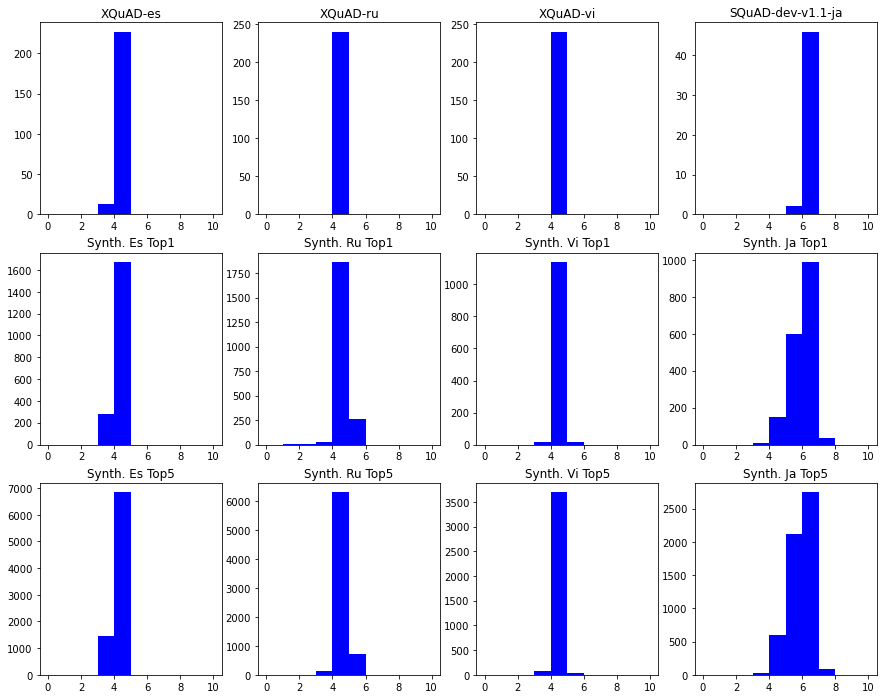

In [15]:
fig, axs = plt.subplots(3, 4)
fig.set_figheight(12)
fig.set_figwidth(15)

dataset_stats = all_stats['xquad-es']
axs[0, 0].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 0].set_title('XQuAD-es')

dataset_stats = all_stats['xquad-ru']
axs[0, 1].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 1].set_title('XQuAD-ru')

dataset_stats = all_stats['xquad-vi']
axs[0, 2].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 2].set_title('XQuAD-vi')

dataset_stats = all_stats['squad-ja']
axs[0, 3].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 3].set_title('SQuAD-dev-v1.1-ja')

dataset_stats = all_stats['synthetic-es-top1']
axs[1, 0].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 0].set_title('Synth. Es Top1')

dataset_stats = all_stats['synthetic-ru-top1']
axs[1, 1].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 1].set_title('Synth. Ru Top1')

dataset_stats = all_stats['synthetic-vi-top1']
axs[1, 2].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 2].set_title('Synth. Vi Top1')

dataset_stats = all_stats['synthetic-ja-top1']
axs[1, 3].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 3].set_title('Synth. Ja Top1')

dataset_stats = all_stats['synthetic-es-top5']
axs[2, 0].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 0].set_title('Synth. Es Top5')

dataset_stats = all_stats['synthetic-ru-top5']
axs[2, 1].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 1].set_title('Synth. Ru Top5')

dataset_stats = all_stats['synthetic-vi-top5']
axs[2, 2].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 2].set_title('Synth. Vi Top5')

dataset_stats = all_stats['synthetic-ja-top5']
axs[2, 3].hist(dataset_stats['entropy_shannon_chars'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 3].set_title('Synth. Ja Top5')

Text(0.5, 1.0, 'Synth. Ja Top5')

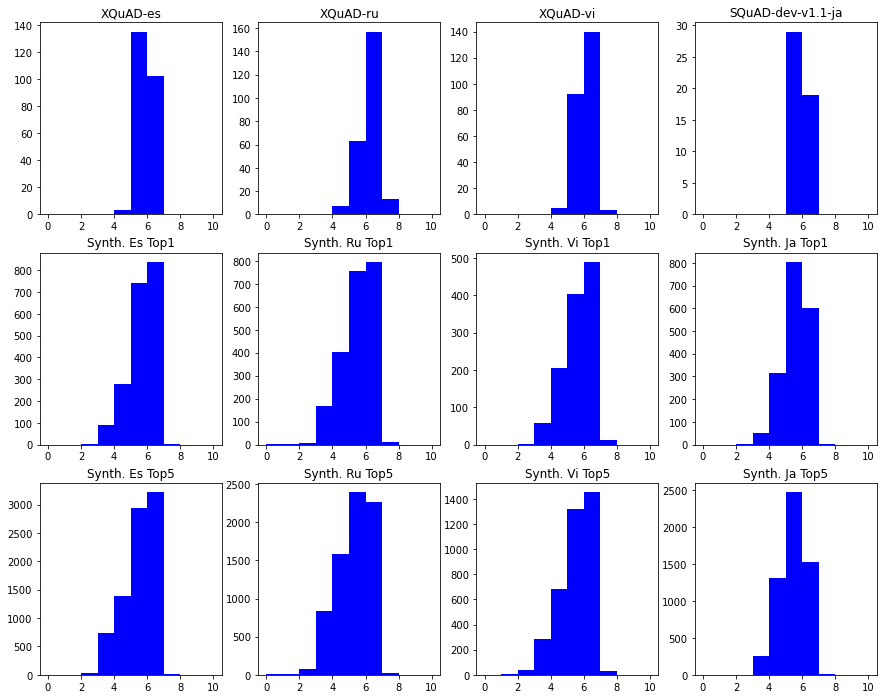

In [16]:
fig, axs = plt.subplots(3, 4)
fig.set_figheight(12)
fig.set_figwidth(15)

dataset_stats = all_stats['xquad-es']
axs[0, 0].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 0].set_title('XQuAD-es')

dataset_stats = all_stats['xquad-ru']
axs[0, 1].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 1].set_title('XQuAD-ru')

dataset_stats = all_stats['xquad-vi']
axs[0, 2].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 2].set_title('XQuAD-vi')

dataset_stats = all_stats['squad-ja']
axs[0, 3].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[0, 3].set_title('SQuAD-dev-v1.1-ja')

dataset_stats = all_stats['synthetic-es-top1']
axs[1, 0].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 0].set_title('Synth. Es Top1')

dataset_stats = all_stats['synthetic-ru-top1']
axs[1, 1].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 1].set_title('Synth. Ru Top1')

dataset_stats = all_stats['synthetic-vi-top1']
axs[1, 2].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 2].set_title('Synth. Vi Top1')

dataset_stats = all_stats['synthetic-ja-top1']
axs[1, 3].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[1, 3].set_title('Synth. Ja Top1')

dataset_stats = all_stats['synthetic-es-top5']
axs[2, 0].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 0].set_title('Synth. Es Top5')

dataset_stats = all_stats['synthetic-ru-top5']
axs[2, 1].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 1].set_title('Synth. Ru Top5')

dataset_stats = all_stats['synthetic-vi-top5']
axs[2, 2].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 2].set_title('Synth. Vi Top5')

dataset_stats = all_stats['synthetic-ja-top5']
axs[2, 3].hist(dataset_stats['entropy_shannon_words'], 10, range=[0, 10], facecolor='blue', align='mid')
axs[2, 3].set_title('Synth. Ja Top5')

In [17]:
min_all_stats = {}
for dataset_name in datasets:
    dataset_stats = all_stats[dataset_name]
    min_all_stats[dataset_name] = {}
    min_all_stats[dataset_name]['n_words_avg'] = st.mean(dataset_stats['n_words'])
    min_all_stats[dataset_name]['n_words_std'] = st.pstdev(dataset_stats['n_words'])
    min_all_stats[dataset_name]['entropy_shannon_chars_avg'] = st.mean(dataset_stats['entropy_shannon_chars'])
    min_all_stats[dataset_name]['entropy_shannon_chars_std'] = st.pstdev(dataset_stats['entropy_shannon_chars'])
    min_all_stats[dataset_name]['entropy_shannon_words_avg'] = st.mean(dataset_stats['entropy_shannon_words'])
    min_all_stats[dataset_name]['entropy_shannon_words_std'] = st.pstdev(dataset_stats['entropy_shannon_words'])
    min_all_stats[dataset_name]['n_words_ps_avg'] = st.mean(dataset_stats['n_words_ps'])
    min_all_stats[dataset_name]['n_words_ps_std'] = st.pstdev(dataset_stats['n_words_ps'])
    min_all_stats[dataset_name]['entropy_shannon_chars_ps_avg'] = st.mean(dataset_stats['entropy_shannon_chars_ps'])
    min_all_stats[dataset_name]['entropy_shannon_chars_ps_std'] = st.pstdev(dataset_stats['entropy_shannon_chars_ps'])
    min_all_stats[dataset_name]['entropy_shannon_words_ps_avg'] = st.mean(dataset_stats['entropy_shannon_words_ps'])
    min_all_stats[dataset_name]['entropy_shannon_words_ps_std'] = st.pstdev(dataset_stats['entropy_shannon_words_ps'])

In [18]:
df = pd.DataFrame.from_dict(min_all_stats, orient='index')
df.head(10)

,n_words_avg,n_words_std,entropy_shannon_chars_avg,entropy_shannon_chars_std,entropy_shannon_words_avg,entropy_shannon_words_std,n_words_ps_avg,n_words_ps_std,entropy_shannon_chars_ps_avg,entropy_shannon_chars_ps_std,entropy_shannon_words_ps_avg,entropy_shannon_words_ps_std
squad,123.157233,54.938413,4.156048,0.084359,5.898966,0.431719,24.634569,13.059698,4.027564,0.171346,4.181797,0.635377
squad-es,127.731495,57.216147,4.122191,0.085970,5.845823,0.424409,24.812823,11.222896,3.967656,0.239799,4.162804,0.692721
squad-ja,171.541667,65.599784,6.425384,0.270676,5.930992,0.270999,33.750000,14.382616,5.187403,0.471981,4.547689,0.460804
xquad-es,143.500000,64.850726,4.127144,0.085160,5.925990,0.390400,28.936975,15.589920,3.980956,0.301793,4.306911,0.663834
xquad-ru,114.062500,51.704129,4.488296,0.131102,6.208548,0.496334,22.107431,11.967603,4.287818,0.254722,4.140133,0.738889
xquad-vi,134.925000,61.878801,4.726816,0.094827,6.091435,0.429948,26.508030,14.236372,4.535884,0.363694,4.295246,0.762709
synthetic-es-top1,132.821301,77.298825,4.131276,0.140975,5.664835,0.784471,25.035987,25.776710,3.772542,0.624313,3.648180,1.377012
synthetic-ru-top1,97.589767,59.742230,4.589776,0.298052,5.530587,0.951051,19.779619,24.380970,3.986515,0.939914,3.382409,1.395856
synthetic-vi-top1,103.674637,62.747287,4.620137,0.222486,5.684840,0.876640,22.016516,23.701923,4.073065,0.950208,3.556558,1.539201
synthetic-ja-top1,128.744800,77.518041,6.004169,0.651930,5.592798,0.725516,40.299577,36.732814,5.057507,0.892387,4.438345,0.972691


In [19]:
save_path = os.path.join(ARTIFACTS_PATH, 'squad-stats.csv')
df.to_csv(save_path)